In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask , dask.distributed
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import matplotlib.colors as colors
from fix_grid import fix_grid 
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from useful_calculations import weighted_means
from scipy import stats
from scipy.stats import linregress

In [2]:
ds_mom=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/MOM5_monthly_0181-0190_noice_all.nc')
pathp='/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/'
pathf='/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/0181-0190/'
dsa=xr.open_dataset(pathf+'3x3box_median_anomaly_monthly_0181-0190_all.nc')
corr=xr.open_dataset(pathf+'3x3box_median_corr_monthly_0181-0190_all.nc')
ds=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/mean_std_control_noice.nc', chunks='auto')
ds_cc=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/mean_std_1PctTo2X_noice.nc', chunks='auto')
ds_mom=fix_grid(ds_mom)
dsa=fix_grid(dsa)
corr=fix_grid(corr)
ds=fix_grid(ds)
ds_cc=fix_grid(ds_cc)

cat=xr.open_dataset(pathf+'categorization_wind.nc').__xarray_dataarray_variable__
cat=fix_grid(cat)
windano=xr.open_dataset(pathf+'3x3box_median_anomaly_monthly_0181-0190_wind.nc').wind_stress
windano=fix_grid(windano)

In [3]:
def boxplot_df(ds,varnames, categorization_no, timestep_index='all'):
    ###returns a dataframe which is well prepared for boxplot plotting
    #ds=list
    #varnames=list
    #categorization_no=int (1-8)
    #timestep_index=int(0-119) or slice(..,..)
    
    cat=xr.open_dataset(pathf+'categorization_wind.nc').__xarray_dataarray_variable__
    varx=ds[0].where(cat==categorization_no)
    vary=ds[1].where(cat==categorization_no)
    if timestep_index!='all':
        
        varx=varx.isel(time=timestep_index)
        vary=vary.isel(time=timestep_index)
    df_x = varx.to_dataframe(name=varnames[0]).reset_index()
    df_y = vary.to_dataframe(name=varnames[1]).reset_index()
    df = pd.merge(df_y, df_x, on=['xt_ocean', 'yt_ocean', 'time'])
    df = df.dropna()
    return df

In [137]:
def boxplot_plotting(df, xbins, varnames, categorization_no, save_path):
    #df=prepared dataframe
    #xbins=array
    #varnames=list with strings
    #categorization_no=int
    ###plots the boxplots

    #-----------------------------------
    #binning
    #-----------------------------------
    xbins = xbins
    bin_labels = np.round(0.5 * (xbins[:-1] + xbins[1:]),3)
    df_x= df[varnames[0]].clip(lower=xbins.min(), upper=xbins.max())
    df['xbins'] = pd.cut(df_x, bins=xbins, labels=bin_labels)
    mean_per_bin = df.groupby('xbins')[varnames[1]].mean().dropna()

    x_bin_centers = mean_per_bin.index.to_numpy(dtype=float)

    positions = [list(bin_labels).index(x) for x in x_bin_centers]

    #-----------------------------------
    #linregression
    #-----------------------------------
    
    y_means = mean_per_bin.values
    
    slope, intercept, r_value, p_value, std_err = linregress(positions, y_means)

    reg_x = np.array([min(positions), max(positions)])
    reg_y = intercept + slope * reg_x

    #-----------------------------------
    #plotting
    #-----------------------------------
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='xbins', y=varnames[1], showfliers=False, color='lightblue')

    plt.plot(reg_x, reg_y, color='red', label='Linear Fit (means)')
    plt.xlabel(varnames[0])
    plt.ylabel(varnames[1])
    plt.title("")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.axhline(y=0, c='black')
    titlelist=["solubility only", "solubility or wind", "wind only", "biology only","biology or wind", "respiration signal only", "respiration or wind", "rest"]
    title=titlelist[categorization_no-1]
    plt.title(title, fontweight='bold')
    
    plt.grid()


    # Add r-value text in top right corner (adjust coordinates as needed)
    plt.text(
        0.95, 0.95, f'$r = {r_value:.2f}$',
        horizontalalignment='right',
        verticalalignment='top',
        transform=plt.gca().transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )
    plt.savefig(save_path, dpi=300,  bbox_inches='tight')
    plt.show()
    ;
    

## apply

### several timesteps

### wind - temperature

In [35]:
test_df=boxplot_df([dsa.SST, windano], ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 1, 0)

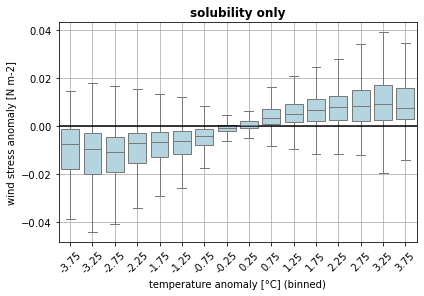

In [74]:
boxplot_plotting(test_df, np.arange(-4, 4 + .5, .5), ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 1)

### one timestep

In [34]:
test_df=boxplot_df([dsa.SST, windano], ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], slice(0,4))

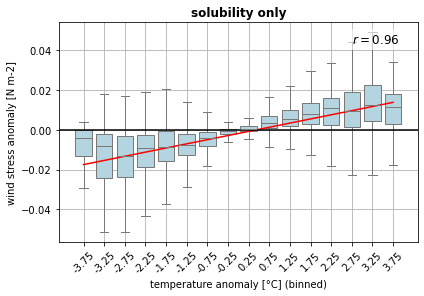

In [46]:
boxplot_plotting(test_df, np.arange(-4, 4 + .5, .5), ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 1,pathp+'binned_sol_only_1.png')

In [37]:
test_df1=boxplot_df([dsa.SST, windano], ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 3, 0)

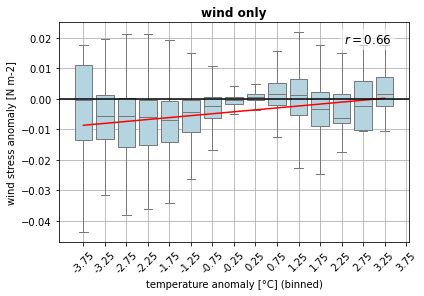

In [47]:
boxplot_plotting(test_df1, np.arange(-4, 4 + .5, .5), ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 3, pathp+'binned_wind_only_1.png')

In [48]:
test_df2=boxplot_df([dsa.SST, windano], ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 2, 0)

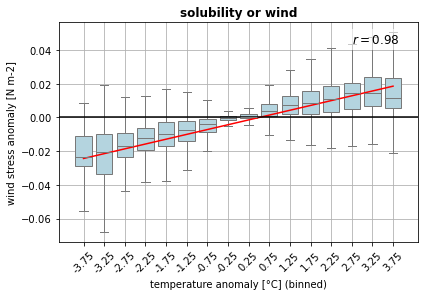

In [49]:
boxplot_plotting(test_df2, np.arange(-4, 4 + .5, .5), ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 2,pathp+'binned_sol_wind_1.png')

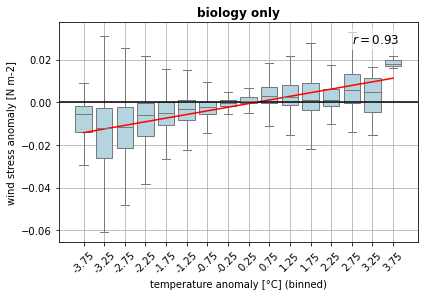

In [51]:
test_df2=boxplot_df([dsa.SST, windano], ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 4, 0)
boxplot_plotting(test_df2, np.arange(-4, 4 + .5, .5), ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 4, pathp+'binned_bio_only_1.png')

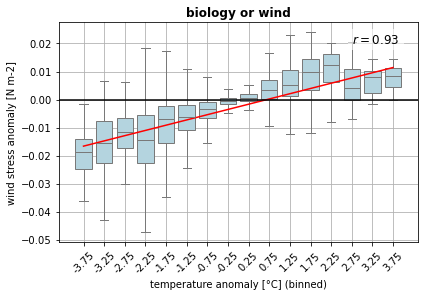

In [50]:
test_df2=boxplot_df([dsa.SST, windano], ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 5, 12)
boxplot_plotting(test_df2, np.arange(-4, 4 + .5, .5), ["temperature anomaly [°C] (binned)", "wind stress anomaly [N m-2]"], 5, pathp+'binned_bio_wind_1.png')

### wind - CO2

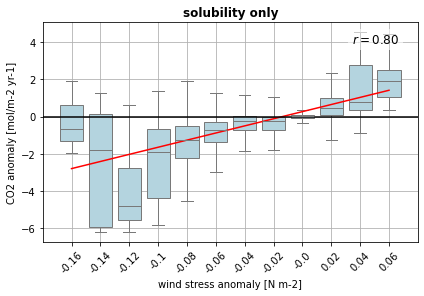

In [138]:
test_df1=boxplot_df([windano, dsa.dic_stf ], ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 1, 0)
boxplot_plotting(test_df1, np.arange(-.21, .22 + .01, .02), ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 1, pathp+'binned_sol_only_2.png')

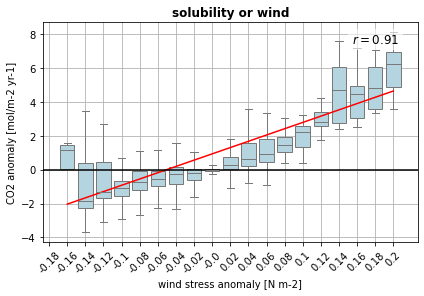

In [139]:
test_df1=boxplot_df([windano, dsa.dic_stf ], ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 2, 0)
boxplot_plotting(test_df1, np.arange(-.21, .22 + .01, .02), ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 2, pathp+'binned_sol_wind_2.png')

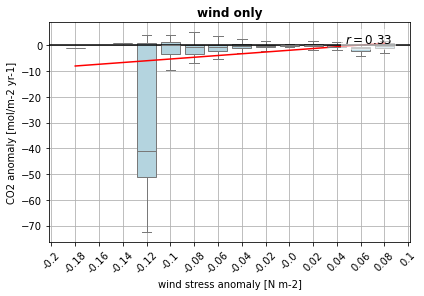

In [140]:
test_df1=boxplot_df([windano, dsa.dic_stf ], ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 3, 0)
boxplot_plotting(test_df1, np.arange(-.21, .22 + .01, .02), ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 3, pathp+'binned_wind_only_2.png')

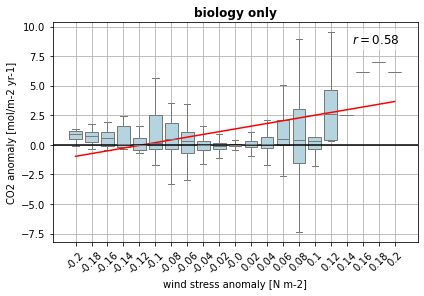

In [141]:
test_df1=boxplot_df([windano, dsa.dic_stf ], ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 4, 0)
boxplot_plotting(test_df1, np.arange(-.21, .22 + .01, .02), ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 4, pathp+'binned_bio_only_2.png')

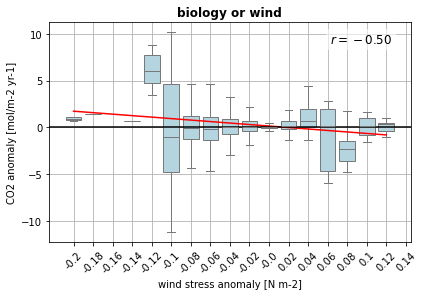

In [142]:
test_df1=boxplot_df([windano, dsa.dic_stf ], ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 5, 0)
boxplot_plotting(test_df1, np.arange(-.21, .22 + .01, .02), ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 5, pathp+'binned_bio_wind_2.png')

### wind - O2

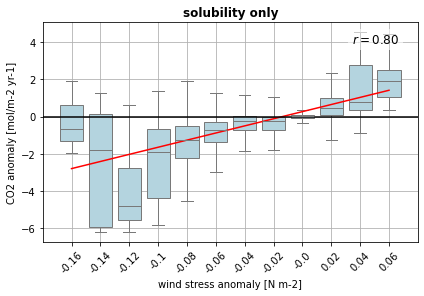

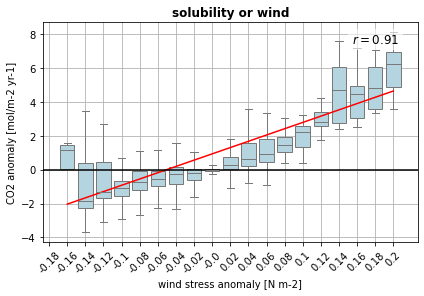

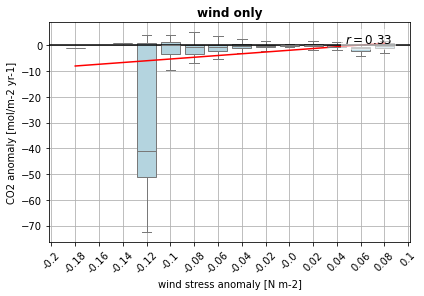

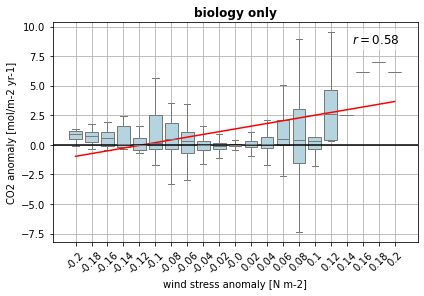

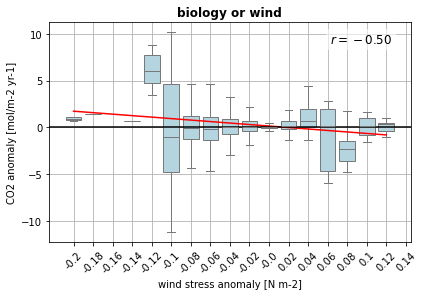

In [143]:
test_df1=boxplot_df([windano, dsa.dic_stf ], ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 1, 0)
boxplot_plotting(test_df1, np.arange(-.21, .22 + .01, .02), ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 1, pathp+'binned_sol_only_3.png')
test_df1=boxplot_df([windano, dsa.dic_stf ], ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 2, 0)
boxplot_plotting(test_df1, np.arange(-.21, .22 + .01, .02), ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 2, pathp+'binned_sol_wind_3.png')
test_df1=boxplot_df([windano, dsa.dic_stf ], ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 3, 0)
boxplot_plotting(test_df1, np.arange(-.21, .22 + .01, .02), ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 3, pathp+'binned_wind_only_3.png')
test_df1=boxplot_df([windano, dsa.dic_stf ], ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 4, 0)
boxplot_plotting(test_df1, np.arange(-.21, .22 + .01, .02), ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 4, pathp+'binned_bio_only_3.png')
test_df1=boxplot_df([windano, dsa.dic_stf ], ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 5, 0)
boxplot_plotting(test_df1, np.arange(-.21, .22 + .01, .02), ["wind stress anomaly [N m-2]", "CO2 anomaly [mol/m-2 yr-1]"], 5, pathp+'binned_bio_wind_3.png')

# Function for slope and mean/median calculation

In [107]:
def slope(varlist, namelist, ds, dswind, ctrl_or_cc):
    ###prints slope and rvalue as well as mean/median values for the selected regions
    #varlist: list of string pairs (variable names) to calculate slope x,y
    #namelist: list of string pairs for printing nicely
    #ds: anomaly dataset
    #dswind: anomaly of wind dataset
    #ctrl_or_cc: 'Ctrl' or 'CC' depending if the dataset is Control or Climate Change
    if ctrl_or_cc=='Ctrl':
        ds=ds[['o2_stf', 'dic_stf', 'SST', 'jp_all']]
        ds_new=xr.merge([ds, dswind])
        SSTA='SST'
    elif ctrl_or_cc=='CC':
        ds=ds[['o2_stf_1PctTo2X', 'dic_stf_1PctTo2X', 'SST_1PctTo2X', 'jp_all_1PctTo2X']]
        ds_new=xr.merge([ds, dswind])
        SSTA='SST_1PctTo2X'

    for i in range(len(varlist)):
        ##calculate slope and pearson corr
        #statistics
        data1=ds_new[varlist[i][0]]
        data2=ds_new[varlist[i][1]]
        var1=namelist[i][0]
        var2=namelist[i][1]
        if data1.isnull().all()==True:
            return "Only nan values"
        elif data2.isnull().all()==True:
            return "Only nan values"

        data1_1d=data1.values.flatten()
        data2_1d=data2.values.flatten()
        mask = ~np.isnan(data1_1d) & ~np.isnan(data2_1d)
        result = stats.linregress(data1_1d[mask],data2_1d[mask]) 
        print('___________'+var1+'-'+var2+':___________') 
        print('slope: '+ str(round(result.slope,3)))
        print('rvalue: '+ str(round(result.rvalue,3)))
        
    #calculate anticyclone and cyclone mean and median
    #anticyclone
    ds_new=ds_new.where(data1.isnull()==False)
    ds_anticycl=ds_new.where(ds_new[SSTA]>0)
    ds_anticycl_means=ds_anticycl.mean()
    ds_anticycl_medians=ds_anticycl.median()
    
    #cyclone
    ds_cycl=ds_new.where(ds_new[SSTA]<0)
    ds_cycl_means=ds_cycl.mean()
    ds_cycl_medians=ds_cycl.median()

        
        
    print('----Anticyclone:----')
    print('--mean values:--')

    test=['mol/m-2 yr', 'mol/m-2 yr', 'degC', 'mol/m-2 yr', 'N/m-2']
    counter=0
    for variable, value in ds_anticycl_means.items():
        if variable=='jp_all':
            print(f"{variable}: {np.round(float(value.values)*60*60*24*365,3)} {test[counter]}")
        elif variable=='wind_stress':
            print(f"{variable}: {np.round(float(value.values)*1000,3)}e-3 {test[counter]}")
      
        else:
            print(f"{variable}: {np.round(float(value.values),3)} {test[counter]}")
        counter=counter+1
    print('--median values:--')
    counter=0
    for variable, value in ds_anticycl_medians.items():
        if variable=='jp_all':
            print(f"{variable}: {np.round(float(value.values)*60*60*24*365,3)} {test[counter]}")
        elif variable=='wind_stress':
            print(f"{variable}: {np.round(float(value.values)*1000,3)}e-3 {test[counter]}")

        else:
            print(f"{variable}: {np.round(float(value.values),3)} {test[counter]}")
        counter=counter+1
    print('----Cyclone:-------- ')
    print('--mean values:--')

    test=['mol/m-2 yr', 'mol/m-2 yr', 'degC', 'mol/m-2 yr', 'N/m-2']
    counter=0
    for variable, value in ds_cycl_means.items():
        if variable=='jp_all':
            print(f"{variable}: {np.round(float(value.values)*60*60*24*365,3)} {test[counter]}")
        elif variable=='wind_stress':
            print(f"{variable}: {np.round(float(value.values)*1000,3)}e-3 {test[counter]}")

        else:
            print(f"{variable}: {np.round(float(value.values),3)} {test[counter]}")
        counter=counter+1
    print('--median values:--')
    counter=0
    for variable, value in ds_cycl_medians.items():
        if variable=='jp_all':
            print(f"{variable}: {np.round(float(value.values)*60*60*24*365,3)} {test[counter]}")
        elif variable=='wind_stress':
            print(f"{variable}: {np.round(float(value.values)*1000,3)}e-3 {test[counter]}")

        else:
            print(f"{variable}: {np.round(float(value.values),3)} {test[counter]}")
        counter=counter+1
#           print()

In [106]:
print('solubility only')
slope([['SST', 'wind_stress'], ['wind_stress', 'dic_stf'], ['wind_stress', 'o2_stf']], [['SST', 'wind stress'], ['wind stress', 'CO2'], ['wind stress', 'O2']], dsa.isel(time=0).where(cat==1), windano.isel(time=0).where(cat==1), 'Ctrl')
print(' ')
print('solubility or wind ')
slope([['SST', 'wind_stress'], ['wind_stress', 'dic_stf'], ['wind_stress', 'o2_stf']], [['SST', 'wind stress'], ['win sstress', 'CO2'], ['wind stress', 'O2']], dsa.isel(time=0).where(cat==2), windano.isel(time=0).where(cat==2), 'Ctrl')
print(' ')
print('wind only')
slope([['SST', 'wind_stress'], ['wind_stress', 'dic_stf'], ['wind_stress', 'o2_stf']], [['SST', 'wind stress'], ['win sstress', 'CO2'], ['wind stress', 'O2']], dsa.isel(time=0).where(cat==3), windano.isel(time=0).where(cat==3), 'Ctrl')
print(' ')
print('biology only')
slope([['SST', 'wind_stress'], ['wind_stress', 'dic_stf'], ['wind_stress', 'o2_stf']], [['SST', 'wind stress'], ['win sstress', 'CO2'], ['wind stress', 'O2']], dsa.isel(time=0).where(cat==4), windano.isel(time=0).where(cat==4), 'Ctrl')
print(' ')
print('biology or wind')
slope([['SST', 'wind_stress'], ['wind_stress', 'dic_stf'], ['wind_stress', 'o2_stf']], [['SST', 'wind stress'], ['win sstress', 'CO2'], ['wind stress', 'O2']], dsa.isel(time=0).where(cat==5), windano.isel(time=0).where(cat==5), 'Ctrl')
print(' ')

solubility only
___________SST-wind stress:___________
slope: 0.006
rvalue: 0.365
___________wind stress-CO2:___________
slope: 29.14
rvalue: 0.315
___________wind stress-O2:___________
slope: 73.751
rvalue: 0.21
----Anticyclone:----
--mean values:--
o2_stf: 0.139 mol/m-2 yr
dic_stf: 0.105 mol/m-2 yr
SST: 0.199 degC
jp_all: 0.014 mol/m-2 yr
wind_stress: 0.951e-3 N/m-2
--median values:--
o2_stf: 0.06 mol/m-2 yr
dic_stf: 0.024 mol/m-2 yr
SST: 0.12 degC
jp_all: 0.002 mol/m-2 yr
wind_stress: 0.502e-3 N/m-2
----Cyclone:-------- 
--mean values:--
o2_stf: -0.269 mol/m-2 yr
dic_stf: -0.076 mol/m-2 yr
SST: -0.193 degC
jp_all: 0.084 mol/m-2 yr
wind_stress: -1.563e-3 N/m-2
--median values:--
o2_stf: -0.041 mol/m-2 yr
dic_stf: -0.011 mol/m-2 yr
SST: -0.117 degC
jp_all: 0.0 mol/m-2 yr
wind_stress: -0.829e-3 N/m-2
 
solubility or wind 
___________SST-wind stress:___________
slope: 0.006
rvalue: 0.353
___________win sstress-CO2:___________
slope: 20.512
rvalue: 0.159
___________wind stress-O2:_______